In [2]:
%matplotlib inline
import numpy as np
from numpy import genfromtxt
from sklearn import cross_validation
from sklearn import datasets

In [3]:
data = datasets.load_boston()
X = data.data
y = data.target
featureNames = data.feature_names

Let's try several linear regression approaches. FIrst, let's plot 

In [4]:
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import matplotlib.pyplot as plt

#plt.scatter(X, y)
#plt.show()

# This function will help to easily compare classifiers
def printScoresAndPlot(X, y, classifier):
    print "Training score: {0}".format(classifier.score(X, y))
    scores = cross_validation.cross_val_score(classifier, X, y, cv=5)
    #print scores
    print "CV score: {0}".format(scores.mean())
    #plt.scatter(X, y)
    #plt.plot(X, classifier.predict(X), color="r")
    #plt.show()

In [5]:
featureNames

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], 
      dtype='|S7')

In [46]:
lr = LinearRegression()
lr.fit(X, y)

printScoresAndPlot(X, y, lr)

print "Theta: {0}".format(np.hstack([lr.intercept_, lr.coef_]))

Training score: 0.740607742865
CV score: 0.350741350933
Theta: [  3.64911033e+01  -1.07170557e-01   4.63952195e-02   2.08602395e-02
   2.68856140e+00  -1.77957587e+01   3.80475246e+00   7.51061703e-04
  -1.47575880e+00   3.05655038e-01  -1.23293463e-02  -9.53463555e-01
   9.39251272e-03  -5.25466633e-01]


In [49]:
# It feels like for multivariate regression linregress does not work...
slope, intercept, rvalue, pvalue, stderr = linregress(X, y)

print rvalue ** 2

ValueError: all the input array dimensions except for the concatenation axis must match exactly

linregress produces the same slope and intercept, however its interface is not as clean as the LinearRegression class. For your information, the p-value determines if the function fulfills the null hypothesis of "slope = 0". A lower value, the better. 

Use the polifit interface

In [50]:
from sklearn.metrics import r2_score

# It seems polyfit only works with 1D arrays...
predictor = np.poly1d(np.polyfit(X, y, deg=1))
r2 = r2_score(y, predictor(X))

print r2

plt.scatter(X, y)
plt.plot(X, predictor(X), color="r")

TypeError: expected 1D vector for x

It seems polyfit only works on 1D features. We'll use the Polynomial Regressor preprocessor

In [60]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=1)
X_ = poly.fit_transform(X)

clf = LinearRegression()
clf.fit(X_, y)
printScoresAndPlot(X_, y, clf)

print "Theta: {0}".format(np.hstack([clf.intercept_, clf.coef_]))

Training score: 0.740607742865
[ 0.63861069  0.71334432  0.58645134  0.07842495 -0.26312455]
CV score: 0.350741350933
Theta: [  3.64911033e+01   0.00000000e+00  -1.07170557e-01   4.63952195e-02
   2.08602395e-02   2.68856140e+00  -1.77957587e+01   3.80475246e+00
   7.51061703e-04  -1.47575880e+00   3.05655038e-01  -1.23293463e-02
  -9.53463555e-01   9.39251272e-03  -5.25466633e-01]


Try out SGDRegressor. Useful and efficient if there are more than 10K samples. For less samples it is less accurate than other regressors though.

In [61]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()
sgd.fit(X, y)
printScoresAndPlot(X, y, sgd)

print "Theta: {0}".format(np.hstack([sgd.intercept_, sgd.coef_]))

Training score: -1.84332497582e+27
[ -2.86880228e+25  -4.38186952e+26  -1.22596057e+26  -2.73820155e+27
  -7.81210211e+26]
CV score: -8.21776558817e+26
Theta: [  1.33885276e+10  -2.84549285e+11  -9.90864956e+11  -2.94382088e+11
  -2.84837133e+09   9.79033021e+09   1.41277058e+11  -7.38366157e+10
  -1.44336804e+11  -1.04821425e+11   9.64434397e+11   3.54366815e+11
  -3.19610291e+10  -7.36031195e+11]


Try out Lasso, which should be more efficient than the linear regressions we've tried. Maybe it's faster, but the achieved score is a bit lower

In [45]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha = 0.1)
lasso.fit(X, y)
printScoresAndPlot(X, y, lasso)

print "Theta: {0}".format(np.hstack([lasso.intercept_, lasso.coef_]))

Training score: 0.726914693175
CV score: 0.401031199074
Theta: [  2.55847704e+01  -9.67879216e-02   4.91792229e-02  -3.64254147e-02
   9.57096983e-01  -0.00000000e+00   3.69894259e+00  -1.00063381e-02
  -1.16012114e+00   2.74111894e-01  -1.45667495e-02  -7.71002522e-01
   1.03266455e-02  -5.69509268e-01]


Try linear SVM. Surprisingly it's working very well for the Cross-validation, so this one would be the best model.

Training score: 0.703426158584
CV score: 0.453792931896


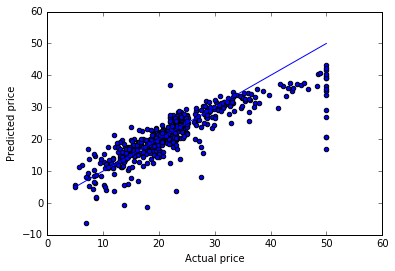

In [11]:
from sklearn import svm

svr = svm.SVR(kernel="linear")
svr.fit(X, y)
printScoresAndPlot(X, y, svr)

# plot predicted vs actual
plt.scatter(y, svr.predict(X))
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.plot([y.min(), y.max()], [[y.min()], [y.max()]])


Let's use Grid search Cross Validation to find the best C and kernel type.

In [8]:
from sklearn.grid_search import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 'C': np.logspace(-10, 0, 10)}
gs = GridSearchCV(svr, parameters, cv=5)
gs.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': array([  1.00000e-10,   1.29155e-09,   1.66810e-08,   2.15443e-07,
         2.78256e-06,   3.59381e-05,   4.64159e-04,   5.99484e-03,
         7.74264e-02,   1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [9]:
gs.best_params_

{'C': 0.077426368268112777, 'kernel': 'linear'}

Now that we found the best C is 0.077426368268112777, let's try it out and compare results

Training score: 0.698256684097
CV score: 0.499741115349


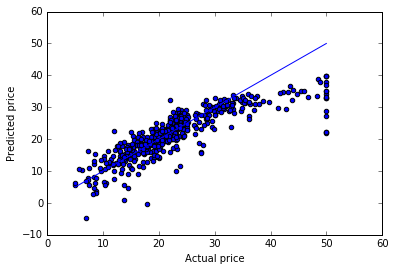

In [12]:
from sklearn import svm

svr = svm.SVR(kernel="linear", C=0.077426368268112777)
svr.fit(X, y)
printScoresAndPlot(X, y, svr)

# plot predicted vs actual
plt.scatter(y, svr.predict(X))
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.plot([y.min(), y.max()], [[y.min()], [y.max()]])

Great! We've improved the Cross-validation score a bit!

In [15]:
np.logspace(-10, 0, 20)

array([  1.00000000e-10,   3.35981829e-10,   1.12883789e-09,
         3.79269019e-09,   1.27427499e-08,   4.28133240e-08,
         1.43844989e-07,   4.83293024e-07,   1.62377674e-06,
         5.45559478e-06,   1.83298071e-05,   6.15848211e-05,
         2.06913808e-04,   6.95192796e-04,   2.33572147e-03,
         7.84759970e-03,   2.63665090e-02,   8.85866790e-02,
         2.97635144e-01,   1.00000000e+00])